In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 8.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import drive
import yfinance as yf
import seaborn as sns
from scipy import stats
# from arch import arch_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Volatility/'

Mounted at /content/drive


# Download data

In [ ]:
start = datetime(2000, 1, 1)
end = datetime(2024, 8, 31)
tckr = '^GSPC'
ticker = yf.Ticker(tckr)
ticker_historical = ticker.history(start=start, end=end, interval="1d")

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(ticker_historical.Close)
plt.title('S&P500 Close Prices', fontsize=20)

Text(0.5, 1.0, 'S&P500 Close Prices')

In [ ]:
log_returns = (np.log(ticker_historical.Close / ticker_historical.Close.shift(1))).dropna()
# weekly_log_returns = daily_log_returns.resample('W').sum()
# monthly_log_returns = daily_log_returns.resample('M').sum()

In [ ]:
first_index = '2000-02-02 00:00:00-05:00'
re_vo = pd.DataFrame(columns=['log_returns', 'volume'], index=log_returns.loc[first_index:].index)
re_vo['log_returns'] = log_returns.loc[first_index:].values
re_vo['volume'] = ticker_historical.Volume[first_index:].values

In [ ]:
re_vo

log_returns      volume
Date                                              
2000-02-02 00:00:00-05:00    -0.000114  1038600000
2000-02-03 00:00:00-05:00     0.011185  1146500000
2000-02-04 00:00:00-05:00    -0.000421  1045100000
2000-02-07 00:00:00-05:00    -0.000091   918100000
2000-02-08 00:00:00-05:00     0.012198  1047700000
...                                ...         ...
2022-12-23 00:00:00-05:00     0.005851  2819280000
2022-12-27 00:00:00-05:00    -0.004058  3030300000
2022-12-28 00:00:00-05:00    -0.012093  3083520000
2022-12-29 00:00:00-05:00     0.017311  3003680000
2022-12-30 00:00:00-05:00    -0.002544  2979870000

[5766 rows x 2 columns]

In [ ]:
# filename = 'returns_&_volume.csv'
# re_vo.to_csv(path + filename)

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(log_returns, color='orange')
plt.title('Daily S&P500 Log Returns', fontsize=20)

Text(0.5, 1.0, 'Daily S&P500 Log Returns')

<ipython-input-7-d01aeaa3afb2>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_returns, norm_hist=True, fit=stats.norm, bins=50)


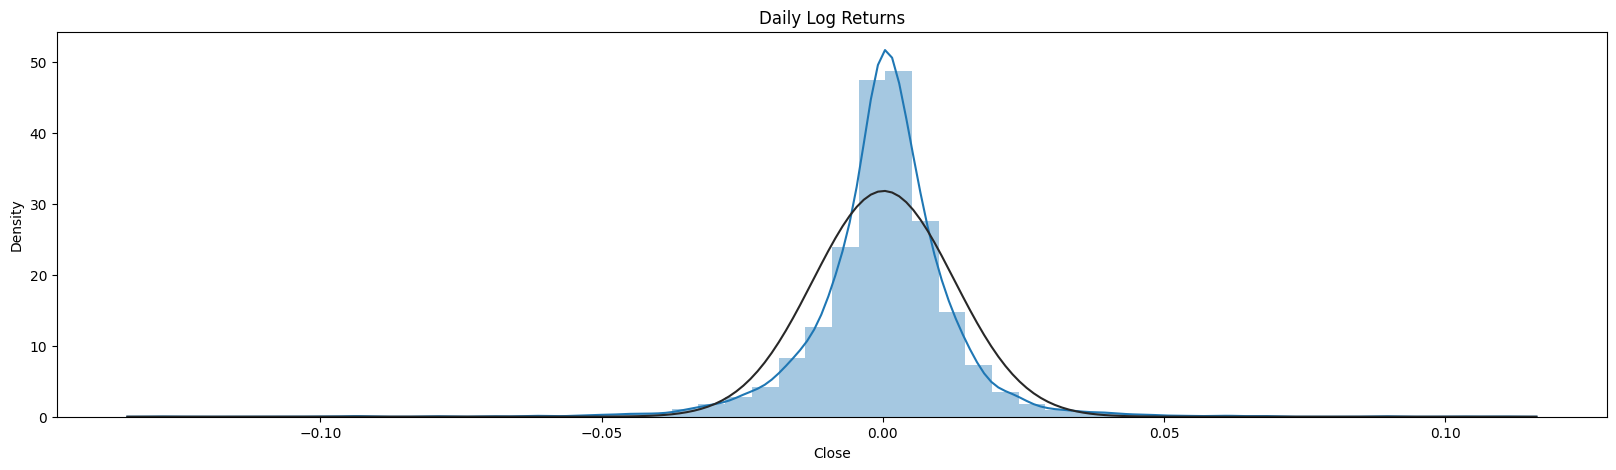

In [ ]:
plt.figure(figsize=(20,5))
sns.distplot(log_returns, norm_hist=True, fit=stats.norm, bins=50)
plt.title('Daily Log Returns')
plt.show()

In [ ]:
# plt.figure(figsize=(15,7))
# plt.plot(weekly_log_returns, color='orange')
# plt.title('Weekly S&P500 Log Returns', fontsize=20)

In [ ]:
# plt.figure(figsize=(20,5))
# sns.distplot(weekly_log_returns, norm_hist=True, fit=stats.norm, bins=50)
# plt.title('Weekly Log Returns')
# plt.show()

In [ ]:
# plt.figure(figsize=(15,7))
# plt.plot(monthly_log_returns, color='orange')
# plt.title('Monthly S&P500 Log Returns', fontsize=20)

In [ ]:
# plt.figure(figsize=(20,5))
# sns.distplot(monthly_log_returns, norm_hist=True, fit=stats.norm, bins=50)
# plt.title('Monthly Log Returns')
# plt.show()

# Calulate historical volatility

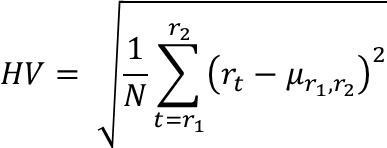

In [ ]:
# def historical_volatility(returns, window_size):
#   historical_volatility = returns.rolling(window=window_size).std()

#   return historical_volatility

In [ ]:
# daily_historical_vols = historical_volatility(log_returns, window_size=21).dropna()
# weekly_historical_vols = historical_volatility(log_returns, window_size=5).dropna()
# monthly_historical_vols = historical_volatility(log_returns, window_size=21).dropna()

In [ ]:
window_size = 21

In [ ]:
daily_historical_vols = log_returns.rolling(window=window_size).std().dropna()

In [ ]:
weekly_historical_vols = daily_historical_vols.rolling(window=5).mean().dropna()

In [ ]:
monthly_historical_vols = daily_historical_vols.rolling(window=20).mean().dropna()

In [ ]:
daily_historical_vols

Date
2000-02-02 00:00:00-05:00    0.016190
2000-02-03 00:00:00-05:00    0.013915
2000-02-04 00:00:00-05:00    0.013915
2000-02-07 00:00:00-05:00    0.013916
2000-02-08 00:00:00-05:00    0.012880
                               ...   
2022-12-23 00:00:00-05:00    0.012892
2022-12-27 00:00:00-05:00    0.012890
2022-12-28 00:00:00-05:00    0.012734
2022-12-29 00:00:00-05:00    0.013430
2022-12-30 00:00:00-05:00    0.011282
Name: Close, Length: 5766, dtype: float64

In [ ]:
weekly_historical_vols

Date
2000-02-08 00:00:00-05:00    0.014163
2000-02-09 00:00:00-05:00    0.013604
2000-02-10 00:00:00-05:00    0.013454
2000-02-11 00:00:00-05:00    0.013449
2000-02-14 00:00:00-05:00    0.013378
                               ...   
2022-12-23 00:00:00-05:00    0.012774
2022-12-27 00:00:00-05:00    0.012837
2022-12-28 00:00:00-05:00    0.012882
2022-12-29 00:00:00-05:00    0.012968
2022-12-30 00:00:00-05:00    0.012645
Name: Close, Length: 5762, dtype: float64

In [ ]:
monthly_historical_vols

Date
2000-03-01 00:00:00-05:00    0.013896
2000-03-02 00:00:00-05:00    0.013699
2000-03-03 00:00:00-05:00    0.013656
2000-03-06 00:00:00-05:00    0.013614
2000-03-07 00:00:00-05:00    0.013625
                               ...   
2022-12-23 00:00:00-05:00    0.014496
2022-12-27 00:00:00-05:00    0.014288
2022-12-28 00:00:00-05:00    0.014111
2022-12-29 00:00:00-05:00    0.013913
2022-12-30 00:00:00-05:00    0.013610
Name: Close, Length: 5747, dtype: float64

In [ ]:
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/Volatility/'

# daily_indexes = daily_historical_vols.index

# df_daily_indexes = pd.DataFrame(daily_indexes, columns=['Date'])
# df_daily_indexes.set_index('Date', inplace=True)

# filename = 'daily_indexes.csv'
# df_daily_indexes.to_csv(path + filename)

# weekly_indexes = weekly_historical_vols.index

# df_weekly_indexes = pd.DataFrame(weekly_indexes, columns=['Date'])
# df_weekly_indexes.set_index('Date', inplace=True)

# filename = 'weekly_indexes.csv'
# df_weekly_indexes.to_csv(path + filename)

# monthly_indexes = monthly_historical_vols.index

# df_monthly_indexes = pd.DataFrame(monthly_indexes, columns=['Date'])
# df_monthly_indexes.set_index('Date', inplace=True)

# filename = 'monthly_indexes.csv'
# df_monthly_indexes.to_csv(path + filename)

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(daily_historical_vols)
plt.title('S&P500 Daily Historical Volatility', fontsize=20)

Text(0.5, 1.0, 'S&P500 Daily Historical Volatility')

Text(0.5, 1.0, 'S&P500 Weekly Historical Volatility')

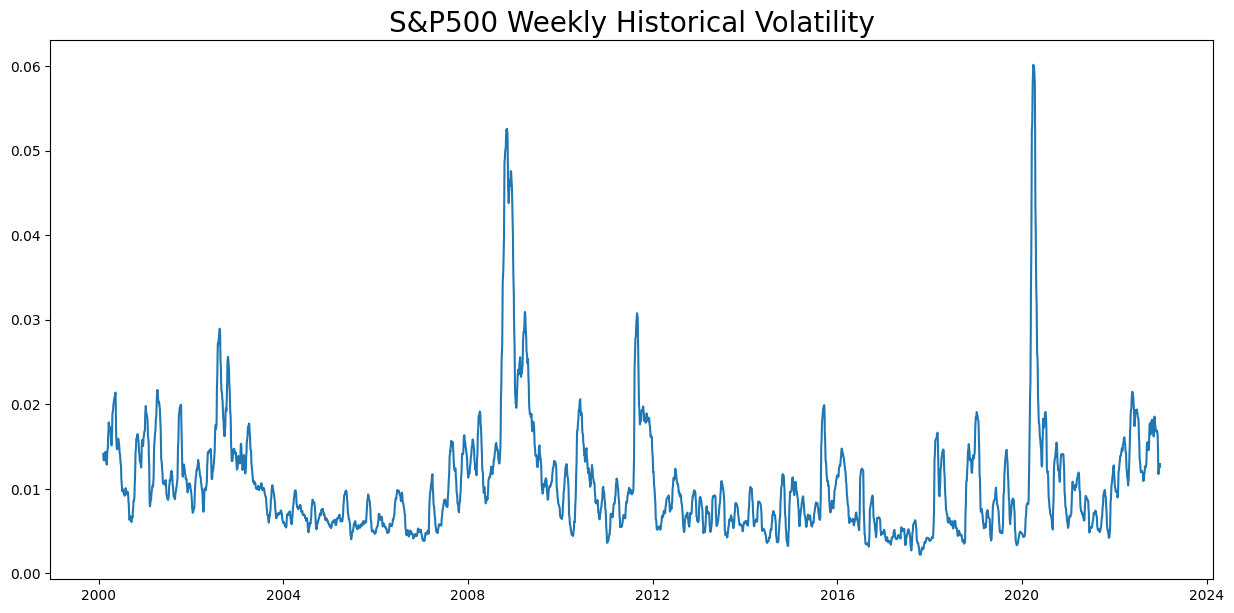

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(weekly_historical_vols)
plt.title('S&P500 Weekly Historical Volatility', fontsize=20)

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(monthly_historical_vols)
plt.title('S&P500 Monthly Historical Volatility', fontsize=20)

Text(0.5, 1.0, 'S&P500 Monthly Historical Volatility')

# Split train, validation and test data

In [ ]:
train_end = datetime(2020, 6, 30)
test_start = datetime(2020, 10, 1)

## Daily data

In [ ]:
daily_historical_vols.index = daily_historical_vols.index.tz_localize(None)
daily_test_vol = daily_historical_vols.loc[test_start:]

In [ ]:
# daily_train_val_vol = daily_historical_vols.loc[:train_end]
# daily_train_vol, daily_val_vol = train_test_split(daily_train_val_vol, test_size=0.1, shuffle=False)

## Weekly data

In [ ]:
weekly_historical_vols.index = weekly_historical_vols.index.tz_localize(None)
weekly_test_vol = weekly_historical_vols.loc[test_start:]

In [ ]:
# weekly_train_val_vol = weekly_historical_vols.loc[:train_end]
# weekly_train_vol, weekly_val_vol = train_test_split(weekly_train_val_vol, test_size=0.1, shuffle=False)

## Monthly data

In [ ]:
monthly_historical_vols.index = monthly_historical_vols.index.tz_localize(None)
monthly_test_vol = monthly_historical_vols.loc[test_start:]

In [ ]:
# monthly_train_val_vol = monthly_historical_vols.loc[:train_end]
# monthly_train_vol, monthly_val_vol = train_test_split(monthly_train_val_vol, test_size=0.1, shuffle=False)

# Create models

In [ ]:
stat_models = ['GARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH']
distribution = ['normal', 'gaussian', 'studentst', 'skewstudent', 'skewt', 'ged']

In [ ]:
daily_garch_data = pd.DataFrame(index=daily_historical_vols.index)
daily_egarch_data = pd.DataFrame(index=daily_historical_vols.index)
daily_figarch_data = pd.DataFrame(index=daily_historical_vols.index)
daily_aparch_data = pd.DataFrame(index=daily_historical_vols.index)
daily_harch_data = pd.DataFrame(index=daily_historical_vols.index)

In [ ]:
# weekly_stats = pd.DataFrame(index=weekly_historical_vols.index)
# mothly_stats = pd.DataFrame(index=monthly_historical_vols.index)

In [ ]:
def stat_model(data, window_size, model_type, dist, p, o, q):
    forecasts = pd.Series(index=data.index)

    for i in range(window_size, len(data) + 1):
        train_data = data.iloc[i - window_size:i]
        model = arch_model(train_data, vol=model_type, p=p, o=o, q=q, dist=dist)
        model_fit = model.fit(disp='off')
        forecast = model_fit.forecast(horizon=1)
        volatility = np.sqrt(forecast.variance.iloc[-1, :].values[0])
        forecasts.iloc[i - 1] = volatility

    return forecasts

### GARCH

In [ ]:
for dist in distribution:
  for o in [0,1]:
    pred = stat_model(log_returns, window_size, 'GARCH', dist, 1, o, 1).dropna()
    daily_garch_data[('GARCH', dist, o)] = pred.values

Streaming output truncated to the last 5000 lines.
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001907. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001901. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This war

In [ ]:
filename = 'daily_garch_data.csv'
daily_garch_data.to_csv(path + filename)

### EGARCH

In [ ]:
daily_egarch_data

In [ ]:
for dist in distribution:
  for o in [0,1]:
    pred = stat_model(log_returns, window_size, 'EGARCH', dist, 1, o, 1).dropna()
    daily_egarch_data[('EGARCH', dist, o)] = pred.values
    print("*************************************************", dist , " with ", o, " done **********************************************************")

Streaming output truncated to the last 5000 lines.
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.972e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.806e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This war

************************************************* normal  with  0  done **********************************************************


Streaming output truncated to the last 5000 lines.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.319e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.053e-05. Parameter
esti

************************************************* normal  with  1  done **********************************************************


Streaming output truncated to the last 5000 lines.
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.972e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.806e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This war

************************************************* gaussian  with  0  done **********************************************************


Streaming output truncated to the last 5000 lines.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.354e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.319e-05. Parameter
estimation work 

************************************************* gaussian  with  1  done **********************************************************


Streaming output truncated to the last 5000 lines.
This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.562e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001254. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by

************************************************* studentst  with  0  done **********************************************************


Streaming output truncated to the last 5000 lines.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.126e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.807e-05. Parameter
estimation work b

************************************************* studentst  with  1  done **********************************************************


Streaming output truncated to the last 5000 lines.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001245. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled b

************************************************* skewstudent  with  0  done **********************************************************


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.114e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.426e-05. Parameter
estimation work better when this v

************************************************* skewstudent  with  1  done **********************************************************


Streaming output truncated to the last 5000 lines.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001245. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled b

************************************************* skewt  with  0  done **********************************************************


Streaming output truncated to the last 5000 lines.
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.432e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.

************************************************* skewt  with  1  done **********************************************************


Streaming output truncated to the last 5000 lines.
This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.365e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.op

************************************************* ged  with  0  done **********************************************************


Streaming output truncated to the last 5000 lines.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.119e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence

************************************************* ged  with  1  done **********************************************************


In [ ]:
daily_egarch_data

(EGARCH, normal, 0)  (EGARCH, normal, 1)  (EGARCH, gaussian, 0)  \
Date                                                                          
2000-02-02             0.093693             0.072215               0.093693   
2000-02-03             0.026853             0.005095               0.026853   
2000-02-04             0.008573             0.004849               0.008573   
2000-02-07             0.056813             0.454779               0.056813   
2000-02-08             0.166669             0.003351               0.166669   
...                         ...                  ...                    ...   
2022-12-23             2.515599             0.014027               2.515599   
2022-12-27             0.000000             0.002557               0.000000   
2022-12-28             0.025266             0.028460               0.025266   
2022-12-29             0.018463             0.012978               0.018463   
2022-12-30             0.010541             0.003376               0.010541   

            (EGARCH, gaussian, 1)  (EGARCH, studentst, 0)  \
Date                                                        
2000-02-02               0.072215            4.904187e-02   
2000-02-03               0.005095            1.170981e+87   
2000-02-04               0.004849           1.340781e+154   
2000-02-07               0.454779            3.476195e-03   
2000-02-08               0.003351            1.304858e-02   
...                           ...                     ...   
2022-12-23               0.014027           1.340781e+154   
2022-12-27               0.002557            0.000000e+00   
2022-12-28               0.028460           1.340781e+154   
2022-12-29               0.012978            1.696717e-02   
2022-12-30               0.003376            2.790185e-02   

            (EGARCH, studentst, 1)  (EGARCH, skewstudent, 0)  \
Date                                                           
2000-02-02            4.746121e-02             1.340781e+154   
2000-02-03            5.457546e+67              5.769505e-02   
2000-02-04            4.413846e-03              2.315022e-02   
2000-02-07            4.947159e-02              6.090110e-02   
2000-02-08            0.000000e+00              1.223193e-02   
...                            ...                       ...   
2022-12-23            1.390906e-02              9.213532e+71   
2022-12-27           1.340781e+154             1.340781e+154   
2022-12-28            5.863803e+00              8.755784e+01   
2022-12-29           1.340781e+154              1.603749e-02   
2022-12-30            3.819152e-02              4.630183e-02   

            (EGARCH, skewstudent, 1)  (EGARCH, skewt, 0)  (EGARCH, skewt, 1)  \
Date                                                                           
2000-02-02              4.945384e-02       1.340781e+154        4.945384e-02   
2000-02-03             1.340781e+154        5.769505e-02       1.340781e+154   
2000-02-04             1.340781e+154        2.315022e-02       1.340781e+154   
2000-02-07             1.340781e+154        6.090110e-02       1.340781e+154   
2000-02-08              6.209773e-02        1.223193e-02        6.209773e-02   
...                              ...                 ...                 ...   
2022-12-23              8.728990e-03        9.213532e+71        8.728990e-03   
2022-12-27              0.000000e+00       1.340781e+154        0.000000e+00   
2022-12-28             1.340781e+154        8.755784e+01       1.340781e+154   
2022-12-29              7.585159e-02        1.603749e-02        7.585159e-02   
2022-12-30              6.710866e-02        4.630183e-02        6.710866e-02   

            (EGARCH, ged, 0)  (EGARCH, ged, 1)  
Date                                            
2000-02-02      3.155652e-02      1.101289e+07  
2000-02-03      1.006050e-02     1.340781e+154  
2000-02-04      2.111134e-02      1.007216e-02  
2000-02-07      4.617593e-02      5.669892e-02  
2000-02-08      0.0000

In [ ]:
filename = 'daily_egarch_data.csv'
daily_egarch_data.to_csv(path + filename)

### FIGARCH

In [ ]:
for dist in distribution:
  for o in [0,1]:
    pred = stat_model(log_returns, window_size, 'FIGARCH', dist, 1, o, 1).dropna()
    daily_figarch_data[('FIGARCH', dist, o)] = pred.values
    print("*************************************************", dist , " with ", o, " done **********************************************************")

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001687. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001725. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-

************************************************* normal  with  0  done **********************************************************


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001649. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001687. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-

************************************************* normal  with  1  done **********************************************************


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001151. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-

************************************************* gaussian  with  0  done **********************************************************


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001649. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-

************************************************* gaussian  with  1  done **********************************************************


Streaming output truncated to the last 5000 lines.
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001815. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warn

************************************************* studentst  with  0  done **********************************************************


Streaming output truncated to the last 5000 lines.
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001905. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warn

************************************************* studentst  with  1  done **********************************************************


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001813. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-

************************************************* skewstudent  with  0  done **********************************************************


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001042. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001059. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-

************************************************* skewstudent  with  1  done **********************************************************


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001813. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-

************************************************* skewt  with  0  done **********************************************************


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001042. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-

************************************************* skewt  with  1  done **********************************************************


Streaming output truncated to the last 5000 lines.
estimating the model parameters. The scale of y is 0.0001917. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001963. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters

************************************************* ged  with  0  done **********************************************************


Streaming output truncated to the last 5000 lines.
estimating the model parameters. The scale of y is 0.0001817. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001846. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters

************************************************* ged  with  1  done **********************************************************


In [ ]:
daily_figarch_data

(FIGARCH, normal, 0)  (FIGARCH, normal, 1)  \
Date                                                     
2000-02-02              0.015799              0.015799   
2000-02-03              0.013579              0.013579   
2000-02-04              0.013582              0.013582   
2000-02-07              0.013580              0.013580   
2000-02-08              0.012567              0.012567   
...                          ...                   ...   
2022-12-23              0.012580              0.012580   
2022-12-27              0.012136              0.012136   
2022-12-28              0.011911              0.011911   
2022-12-29              0.013106              0.013106   
2022-12-30              0.011102              0.011102   

            (FIGARCH, gaussian, 0)  (FIGARCH, gaussian, 1)  \
Date                                                         
2000-02-02                0.015799                0.015799   
2000-02-03                0.013579                0.013579   
2000-02-04                0.013582                0.013582   
2000-02-07                0.013580                0.013580   
2000-02-08                0.012567                0.012567   
...                            ...                     ...   
2022-12-23                0.012580                0.012580   
2022-12-27                0.012136                0.012136   
2022-12-28                0.011911                0.011911   
2022-12-29                0.013106                0.013106   
2022-12-30                0.011102                0.011102   

            (FIGARCH, studentst, 0)  (FIGARCH, studentst, 1)  \
Date                                                           
2000-02-02                 0.017098                 0.017098   
2000-02-03                 0.013791                 0.013791   
2000-02-04                 0.013773                 0.013773   
2000-02-07                 0.013765                 0.013765   
2000-02-08                 0.012728                 0.012728   
...                             ...                      ...   
2022-12-23                 0.012606                 0.012606   
2022-12-27                 0.012111                 0.012111   
2022-12-28                 0.012011                 0.012011   
2022-12-29                 0.013103                 0.013103   
2022-12-30                 0.012223                 0.012223   

            (FIGARCH, skewstudent, 0)  (FIGARCH, skewstudent, 1)  \
Date                                                               
2000-02-02                   0.015942                   0.015942   
2000-02-03                   0.013624                   0.013624   
2000-02-04                   0.013627                   0.013627   
2000-02-07                   0.013625                   0.013625   
2000-02-08                   3.414179                   3.414179   
...                               ...                        ...   
2022-12-23                   0.012598                   0.012598   
2022-12-27                   0.012282                   0.012282   
2022-12-28                   0.012010                   0.012010   
2022-12-29                   0.012281                   0.012281   
2022-12-30                   0.011670                   0.011670   

            (FIGARCH, skewt, 0)  (FIGARCH, skewt, 1)  (FIGARCH, ged, 0)  \
Date                                                                      
2000-02-02             0.015942             0.015942           0.016326   
2000-02-03             0.013624             0.013624           0.013706   
2000-02-04             0.013627             0.013627           0.013823   
2000-02-07             0.013625             0.013625           0.012836   
2000-02-08             3.414179             3.414179           0.012754   
...                         ...                  ...                ...   
2022-12-23             0.012598             0.012598           0.012598   
2022-12-27             0.012282             0.012282     

In [ ]:
filename = 'daily_figarch_data.csv'
daily_figarch_data.to_csv(path + filename)

### APARCH

In [ ]:
print('Hello')

In [ ]:
for dist in distribution:
  for o in [0,1]:
    pred = stat_model(log_returns, window_size, 'APARCH', dist, 1, o, 1).dropna()
    daily_aparch_data[('APARCH', dist, o)] = pred.values

Streaming output truncated to the last 5000 lines.
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.807e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.221e-05. Parameter
estimation work better when thi

In [ ]:
daily_aparch_data

(APARCH, normal, 0)  (APARCH, normal, 1)  (APARCH, gaussian, 0)  \
Date                                                                          
2000-02-02             0.014045             0.009357               0.014045   
2000-02-03             0.014873             0.010568               0.014873   
2000-02-04             0.013613             0.013126               0.013613   
2000-02-07             0.013026             0.199227               0.013026   
2000-02-08             0.013190             0.011789               0.013190   
...                         ...                  ...                    ...   
2022-12-23             0.011573             0.011573               0.011573   
2022-12-27             0.010390             0.010391               0.010390   
2022-12-28             0.010061             0.010059               0.010061   
2022-12-29             0.011815             0.011807               0.011815   
2022-12-30             0.011781             0.011783               0.011781   

            (APARCH, gaussian, 1)  (APARCH, studentst, 0)  \
Date                                                        
2000-02-02               0.009357                0.014077   
2000-02-03               0.010568                0.015870   
2000-02-04               0.013126                0.013769   
2000-02-07               0.199227                0.012893   
2000-02-08               0.011789                0.013119   
...                           ...                     ...   
2022-12-23               0.011573                0.011864   
2022-12-27               0.010391                0.010435   
2022-12-28               0.010059                0.010127   
2022-12-29               0.011807                0.011936   
2022-12-30               0.011783                0.011982   

            (APARCH, studentst, 1)  (APARCH, skewstudent, 0)  \
Date                                                           
2000-02-02                0.009358                  0.014149   
2000-02-03                0.015684                  0.015381   
2000-02-04                0.013234                  0.013666   
2000-02-07                0.008507                  0.012782   
2000-02-08                0.011836                  0.013864   
...                            ...                       ...   
2022-12-23                0.011866                  0.012164   
2022-12-27                0.010441                  0.010866   
2022-12-28                0.010188                  0.010551   
2022-12-29                0.011801                  0.011892   
2022-12-30                0.011980                  0.011823   

            (APARCH, skewstudent, 1)  (APARCH, skewt, 0)  (APARCH, skewt, 1)  \
Date                                                                           
2000-02-02                  0.009364            0.014149            0.009364   
2000-02-03                  0.013225            0.015381            0.013225   
2000-02-04                  0.013030            0.013666            0.013030   
2000-02-07                  0.107800            0.012782            0.107800   
2000-02-08                  0.012768            0.013864            0.012768   
...                              ...                 ...                 ...   
2022-12-23                  0.012205            0.012164            0.012205   
2022-12-27                  0.010904            0.010866            0.010904   
2022-12-28                  0.009362            0.010551            0.009362   
2022-12-29                  0.011786            0.011892            0.011786   
2022-12-30                  0.011832            0.011823            0.011832   

            (APARCH, ged, 0)  (APARCH, ged, 1)  
Date                                            
2000-02-02          0.014471          0.009372  
2000-02-03          0.015214          0.015222  
2000-02-04          0.013909          0.013305  
2000-02-07          0.011881          0.002931  
2000-02-08          0.

In [ ]:
filename = 'daily_aparch_data.csv'
daily_aparch_data.to_csv(path + filename)

### HARCH

In [ ]:
for dist in distribution:
  for o in [0,1]:
    pred = stat_model(log_returns, window_size, 'HARCH', dist, 1, o, 1).dropna()
    daily_harch_data[('HARCH', dist, o)] = pred.values

Streaming output truncated to the last 5000 lines.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.707e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.683e-05. Parameter
estimation work better when this value is between 1 and 1000. The

In [ ]:
daily_harch_data

(HARCH, normal, 0)  (HARCH, normal, 1)  (HARCH, gaussian, 0)  \
Date                                                                       
2000-02-02            0.015800            0.015800              0.015800   
2000-02-03            0.006667            0.006667              0.006667   
2000-02-04            0.011363            0.011363              0.011363   
2000-02-07            0.006046            0.006046              0.006046   
2000-02-08            0.008331            0.008331              0.008331   
...                        ...                 ...                   ...   
2022-12-23            0.004026            0.004026              0.004026   
2022-12-27            0.010063            0.010063              0.010063   
2022-12-28            0.009571            0.009571              0.009571   
2022-12-29            0.013759            0.013759              0.013759   
2022-12-30            0.006728            0.006728              0.006728   

            (HARCH, gaussian, 1)  (HARCH, studentst, 0)  \
Date                                                      
2000-02-02              0.015800               0.017099   
2000-02-03              0.006667               0.013776   
2000-02-04              0.011363               0.013768   
2000-02-07              0.006046               0.026940   
2000-02-08              0.008331               0.012734   
...                          ...                    ...   
2022-12-23              0.004026               0.012607   
2022-12-27              0.010063               0.012610   
2022-12-28              0.009571               0.013209   
2022-12-29              0.013759               0.013112   
2022-12-30              0.006728               0.011078   

            (HARCH, studentst, 1)  (HARCH, skewstudent, 0)  \
Date                                                         
2000-02-02               0.017099                 0.015942   
2000-02-03               0.013776                 0.025485   
2000-02-04               0.013768                 0.013571   
2000-02-07               0.026940                 0.012491   
2000-02-08               0.012734                 0.020622   
...                           ...                      ...   
2022-12-23               0.012607                 0.012598   
2022-12-27               0.012610                 0.035105   
2022-12-28               0.013209                 0.012427   
2022-12-29               0.013112                 0.025527   
2022-12-30               0.011078                 0.033451   

            (HARCH, skewstudent, 1)  (HARCH, skewt, 0)  (HARCH, skewt, 1)  \
Date                                                                        
2000-02-02                 0.015942           0.015942           0.015942   
2000-02-03                 0.025485           0.025485           0.025485   
2000-02-04                 0.013571           0.013571           0.013571   
2000-02-07                 0.012491           0.012491           0.012491   
2000-02-08                 0.020622           0.020622           0.020622   
...                             ...                ...                ...   
2022-12-23                 0.012598           0.012598           0.012598   
2022-12-27                 0.035105           0.035105           0.035105   
2022-12-28                 0.012427           0.012427           0.012427   
2022-12-29                 0.025527           0.025527           0.025527   
2022-12-30                 0.033451           0.033451           0.033451   

            (HARCH, ged, 0)  (HARCH, ged, 1)  
Date                                          
2000-02-02         0.016326         0.016326  
2000-02-03         0.007379         0.007379  
2000-02-04         0.010459         0.010459  
2000-02-07         0.005692         0.005692  
2000-02-08         0.008852         0.008852  
...                     ...              ...  
2022-12-23         0.013729         0.013729  
2022-12-27         0.00

In [ ]:
filename = 'daily_harch_data.csv'
daily_harch_data.to_csv(path + filename)